In [71]:
import pandas as pd
import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
import xgboost
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

In [72]:
import sklearn
sklearn.__version__

'0.19.1'

In [73]:
train_df = pd.read_table('round1_ijcai_18_train_20180301.txt',sep=' ')
test_df = pd.read_table('round1_ijcai_18_test_a_20180301.txt',sep=' ')
train_df = train_df.append(test_df)

In [74]:
def extract_date(x):
    d = datetime.fromtimestamp(x)
    return d.strftime('%Y-%m-%d')
def extract_weekday(x):
    d = datetime.fromtimestamp(x)
    return d.weekday()
def extract_hour(x):
    d = datetime.fromtimestamp(x)
    return d.hour
train_df['date'] = train_df['context_timestamp'].apply(lambda x: extract_date(x))
train_df['weekday'] = train_df['context_timestamp'].apply(lambda x: extract_weekday(x))
train_df['hour'] = train_df['context_timestamp'].apply(lambda x: extract_hour(x))

m = {}
for idx, date in enumerate(sorted(train_df['date'].unique())):
    m[date]=idx
print(m)

for idx, d in enumerate(sorted(train_df['date'].unique())):
    train_df["day"] = train_df['date'].map(lambda x: m[x])

{'2018-09-18': 0, '2018-09-19': 1, '2018-09-20': 2, '2018-09-21': 3, '2018-09-22': 4, '2018-09-23': 5, '2018-09-24': 6, '2018-09-25': 7}


In [112]:
train_df.columns

Index(['context_id', 'context_page_id', 'context_timestamp', 'instance_id',
       'is_trade', 'item_brand_id', 'item_category_list', 'item_city_id',
       'item_collected_level', 'item_id', 'item_price_level',
       'item_property_list', 'item_pv_level', 'item_sales_level',
       'predict_category_property', 'shop_id', 'shop_review_num_level',
       'shop_review_positive_rate', 'shop_score_delivery',
       'shop_score_description', 'shop_score_service', 'shop_star_level',
       'user_age_level', 'user_gender_id', 'user_id', 'user_occupation_id',
       'user_star_level', 'date', 'weekday', 'hour', 'day'],
      dtype='object')

In [75]:
item_list_df = train_df['item_category_list'].str.split(';', expand=True)
# item_list_df.columns = ['item_category_1','item_category_2','item_category_3']
train_df['item_category_0'] = item_list_df[0].replace([None],-1).astype('int64')
train_df['item_category_1'] = item_list_df[1].replace([None],-1).astype('int64')
train_df['item_category_2'] = item_list_df[2].replace([None],-1).astype('int64')

In [76]:
used_features = [
    'item_id', 
    'shop_id',
    'item_brand_id',
    'item_city_id',
    #'item_category_0',
    'item_category_1',
    'item_category_2',
#    'item_property_richness',
#     'user_id', 
#     'context_id',
    'item_price_level', 'item_sales_level',
       'item_collected_level', 'item_pv_level', 
    'user_gender_id',
       'user_age_level', 
    #'user_occupation_id', 
    'user_star_level', 
       'context_page_id', 
       'shop_review_num_level', 'shop_review_positive_rate',
       'shop_star_level', 
    'shop_score_service', 'shop_score_delivery',
       'shop_score_description','day','weekday','hour']


In [77]:
train_all_X = train_df.copy()
train_all_Y = train_all_X['is_trade']
del train_all_X['is_trade']

In [78]:
#X_train, X_val, y_train, y_val = train_test_split( train_all_X, train_all_Y, test_size=0.05, shuffle=False)
X_val = train_all_X.loc[train_all_X["day"]==6][used_features]
X_train = train_all_X.loc[(train_all_X["day"]<6)][used_features]
y_val = train_all_Y.loc[train_all_X["day"]==6]
y_train = train_all_Y.loc[(train_all_X["day"]<6)]
X_test = train_all_X.loc[train_all_X["day"]==7][used_features+['instance_id']]


In [79]:
X_val_a, X_val_b, y_val_a, y_val_b = train_test_split( X_val, y_val, test_size=0.7, shuffle=True, random_state=6)

In [545]:
X_test.columns

Index(['item_id', 'shop_id', 'item_brand_id', 'item_city_id',
       'item_category_1', 'item_category_2', 'item_property_richness',
       'item_price_level', 'item_sales_level', 'item_collected_level',
       'item_pv_level', 'user_gender_id', 'user_age_level', 'user_star_level',
       'context_page_id', 'shop_review_num_level', 'shop_review_positive_rate',
       'shop_star_level', 'shop_score_service', 'shop_score_delivery',
       'shop_score_description', 'day', 'weekday', 'hour', 'instance_id'],
      dtype='object')

In [83]:
xgb = xgboost.XGBClassifier(n_jobs=7,max_depth=5,n_estimators=100,min_child_weight=5, scale_pos_weight=1)
xgb.fit(X_train, y_train)
#823278: max_depth=7,n_estimators=100,min_child_weight=5
#822843: max_depth=7,n_estimators=95,min_child_weight=5
#822423_a_829159: max_depth=7,n_estimators=100,min_child_weight=5 (category_list)
#822339_a_830962: max_depth=5,n_estimators=100,min_child_weight=5 remove user_occupation_id
#821804_a_829159 max_depth=5,n_estimators=100,min_child_weight=5 (remove user_occupation_id,shop_star_level)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=5, missing=None, n_estimators=100,
       n_jobs=7, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [84]:
log_loss(y_val,xgb.predict_proba(X_val))
#0.00011

0.08223397601045268

In [85]:
log_loss(y_val_a,xgb.predict_proba(X_val_a))


0.08309625384796966

In [435]:
sum(y_val == 1) / len(y_val)

0.016910189651869526

In [436]:
sum(y_val_a == 1) / len(y_val_a)

0.017241379310344827

In [437]:
sum(y_val_b == 1) / len(y_val_b)

0.016768254758054484

In [479]:
log_loss(y_val_b,xgb.predict_proba(X_val_b))


0.08186443755967353

In [14]:
def output_to_file(model,df,file_name):
    instance_id_list = df[["instance_id"]]
    print (instance_id_list)
    del df["instance_id"]
    predicted_score = pd.DataFrame(model.predict_proba(df))
    instance_id_list["predicted_score"] = predicted_score[1]
    instance_id_list.to_csv(file_name,index=False,sep=' ')

In [36]:
# refit
xgb.fit(X_train.append(X_val), y_train.append(y_val))


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=5, missing=None, n_estimators=100,
       n_jobs=7, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [37]:
output_to_file(xgb,X_test,"xgb_all_821804_a_829159_refit.csv")

               instance_id
0      2475218615076601065
1       398316874173557226
2      6586402638209028583
3      1040996105851528465
4      6316278569655873454
5       868158305045921978
6      5713520501786699854
7       932945015407923184
8      1919197847086752313
9       304887065966615346
10        3282556850371665
11     8829646398295427742
12     3177704368658581090
13      331811904131229654
14     1529584165704680903
15      410957802501821801
16     7858701120525579871
17     1007593432911733192
18     6933421324008829721
19      949601458836318592
20     1204371563787795352
21     6697124581068234934
22     7458626674337135052
23     6451011837344535814
24     4970342844069330588
25     1311037283502827477
26     5367830782177104937
27      130085071580390177
28     5277248246761080968
29     8248237544078109435
30     8160495387552112248
31     4990633888389156703
32     5367915129338412746
33     7166315717760973347
34     3922408194130789536
35     3198031054131887410
3

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


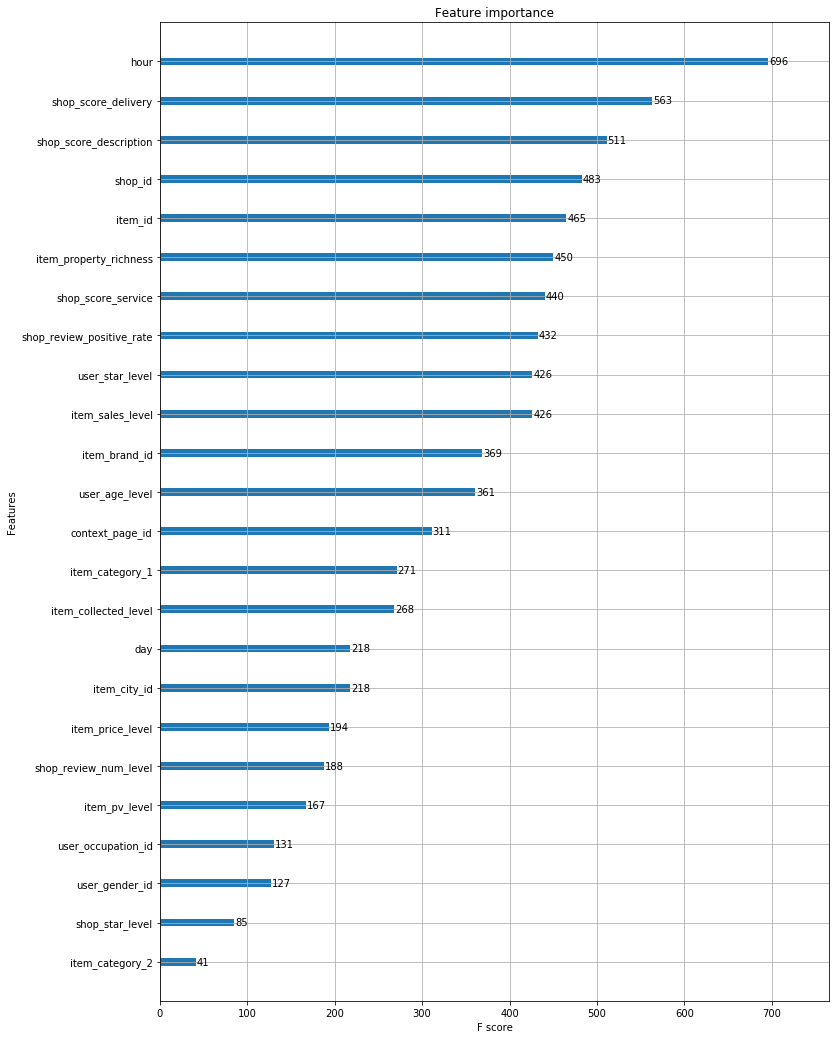

In [540]:
fig,ax = plt.subplots(figsize=(12,18))
xgboost.plot_importance(xgb,ax=ax)
plt.show()